In [2]:
import simuOpt
simuOpt.setOptions(alleleType='lineage', quiet=True)
import simuPOP as sim
import simuPOP.utils
import simuPOP.lutils
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import pandas as pd
import numpy as np
import random
import datetime as dt
import itertools as ite
import seaborn as sns
sns.set(context='paper', style='ticks', palette="Set2", font='sans-serif')
nucleotides = ['A','C','G','T','D','I']
nucleotideTranslator = {
    'A':0,
    'C':1,
    'G':2,
    'T':3,
    '-':4,
    '+':5}
from wgs import crosses, operators, parameterizer, parser
N=26
parse = parser.Parser()
param = parameterizer.Parameterizer()
f1Crosses = crosses.fOne()
f2Crosses = crosses.fTwo()
qtl = parameterizer.QTL()
ae = parameterizer.AE()
ld = parameterizer.LD()
pc = crosses.PC()
mavs = pd.DataFrame()
def preparePopulation():
    header, mapdata, mapsubset=parse.mapParser('hapmap3.txt')
    ends, chromdistances = parse.endPtFinder(mapsubset)
    founderPopulation=sim.Population(N, loci=chromdistances, 
                                 alleleNames=nucleotides, 
                                 infoFields=['ind_id',
                                            'father_id','mother_id',
                                            'ge','pe','fitness'])
    param.genotypeSetter(founderPopulation,'neat.txt')
    f1 = f1Crosses.fOneCross(founderPopulation, size=1, female_idx=1, male_idx=6)
    # F2 population size
    M = 2000
    pop = f2Crosses.fTwoCross(f1, M)
    absQTL, propQTL = qtl.segChooser(f2, 20)
    pop.dvars().qtl = absQTL; pop.dvars().properQTL = propQTL
    alleleEffects, plotAlleleEffects = ae.exponential(f2, 20)
    pop.dvars().alleleEffects = alleleEffects; pop.dvars().plottingAlleleEffects = plotAlleleEffects
    #pop.dvars().lociPairs = ld.generateLociPairs(pop, ends)
    sim.tagID(pop, reset=True)
    #selection_intensity = .05
    #f2.dvars().selectionIntensity = selection_intensity
    #number_of_selected = f2.popSize() * selection_intensity
    #remainder = f2.popSize() - number_of_selected
    #number_of_breeding_subpops = int(number_of_selected / 5)
    #list_of_applicable_subpops = list(range(1, number_of_breeding_subpops))
    exec('import pandas as pd', f2.vars(), f2.vars())
    exec('import itertools as ite', f2.vars(), f2.vars())
    exec('import datetime as dt', f2.vars(), f2.vars())
    exec('import matplotlib.pyplot as plt', f2.vars(), f2.vars())
    return pop.clone()

In [17]:
# Regular evolution
#f2 = preparePopulation()
f2.evolve(
    initOps=[
        operators.InitGenerationToZero(),
        operators.InitializeMultiGenDataMatrix([
                                      'smean_ge','svar_ge','smean_pe','svar_pe',
                                      'umean_ge','uvar_ge','umean_pe','uvar_pe']),
        sim.Stat(popSize=True),
        sim.PyEval(r"'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations\n'"),
        ],
    preOps=[
        operators.GenotypicEffectCalculator(g_effect_field='ge'),
        operators.TruncationSelection(0.7,-101, infoFields=['ge','pe']),
        sim.Stat(meanOfInfo=['ge','pe'], varOfInfo=['ge','pe']),
        sim.Stat(alleleFreq=sim.ALL_AVAIL),
        #GenerateLDPlot('sample-All-Chromosome-LD-plot'),
        #sim.Stat(numOfSegSites=sim.ALL_AVAIL),
        #sim.Stat(effectiveSize=sim.ALL_AVAIL),
        #sim.Stat(neutrality=sim.ALL_AVAIL),
        sim.Stat(structure=sim.ALL_AVAIL, vars=['F_st']),
        GenerateMinorAlleleList(),
        MinorAlleleCounter(),
        sim.PyEval(r"'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], varOfInfo['ge'])"),
        sim.PyEval(r"'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo['pe'], subPopSize)"),
        operators.TestFileWriter(dt.datetime.now(), 'alleleFrequencies'),
        operators.Sorter('pe'),
        sim.SplitSubPops(sizes=[5]*20+[1900], randomize=False),
        operators.CalcSplitMavs('ge','pe','smean_ge','svar_ge','smean_pe','svar_pe',
              'umean_ge','uvar_ge','umean_pe','uvar_pe'),
        ],
    matingScheme=
            sim.HomoMating(
                sim.PyParentsChooser(pc.recursivePairwiseParentChooser),
                sim.OffspringGenerator(ops=[
                    sim.Recombinator(rates=0.01),
                    sim.IdTagger(),
                    sim.PedigreeTagger()],
                    numOffspring=1),
                subPopSize=[50]*20+[0],
                subPops=list(range(1,60)),
                ),
    postOps=[
        sim.MergeSubPops(),
        operators.SelectRandomSeed(1000),
        ],
    gen=5)

Applied <simuPOP.PyOperator> calling a Python function setGenerationToZero: 0
Applied <simuPOP.PyOperator> calling a Python function createMultiGenDataMatrix: 0
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate population size
</ul>: 0.001
Applied <simuPOP.PyEval> evalulate expression "'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations... ": 0
Start evolution.: 0
Applied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.171
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
A

Gen	MeanGe	VarGe	MeanPe	VarPe	SubPopulations



pplied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate allele frequency at all loci
</ul>: 0.202
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function fileWriter: 0.069
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.01
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 0: 0
Mating finished.: 0.363
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.012
Applied <simuPOP.PyOperator> calling a Python function minorAlleleListGenerator: 0.004
A

0	5.894	0.049	5.897	0.055	[2000]


pplied <simuPOP.PyOperator> calling a Python function minorAlleleCounter: 1.68


1

In [ ]:
# Regular evolution
#f2 = preparePopulation()
simf2.evolve(
    initOps=[
        operators.InitGenerationToZero(),
        operators.InitializeMultiGenDataMatrix([
                                      'smean_ge','svar_ge','smean_pe','svar_pe',
                                      'umean_ge','uvar_ge','umean_pe','uvar_pe']),
        sim.Stat(popSize=True),
        sim.PyEval(r"'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations\n'", reps=0),
        ],
    preOps=[
        operators.GenotypicEffectCalculator(g_effect_field='ge'),
        operators.TruncationSelection(0.7,-101, infoFields=['ge','pe']),
        sim.Stat(meanOfInfo=['ge','pe'], varOfInfo=['ge','pe']),
        sim.Stat(alleleFreq=sim.ALL_AVAIL),
        #GenerateLDPlot('sample-All-Chromosome-LD-plot'),
        #sim.Stat(numOfSegSites=sim.ALL_AVAIL),
        #sim.Stat(effectiveSize=sim.ALL_AVAIL),
        #sim.Stat(neutrality=sim.ALL_AVAIL),
        sim.Stat(structure=sim.ALL_AVAIL, vars=['F_st']),
        GenerateMinorAlleleList(),
        MinorAlleleCounter(),
        sim.PyEval(r"'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], varOfInfo['ge'])"),
        sim.PyEval(r"'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo['pe'], subPopSize)"),
        operators.TestFileWriter(dt.datetime.now(), 'alleleFrequencies'),
        operators.Sorter('pe'),
        sim.SplitSubPops(sizes=[5]*20+[1900], randomize=False),
        operators.CalcSplitMavs('ge','pe','smean_ge','svar_ge','smean_pe','svar_pe',
              'umean_ge','uvar_ge','umean_pe','uvar_pe'),
        ],
    matingScheme=
            sim.HomoMating(
                sim.PyParentsChooser(pc.recursivePairwiseParentChooser),
                sim.OffspringGenerator(ops=[
                    sim.Recombinator(rates=0.01),
                    sim.IdTagger(),
                    sim.PedigreeTagger()],
                    numOffspring=1),
                subPopSize=[50]*20+[0],
                subPops=list(range(1,60)),
                ),
    postOps=[
        sim.MergeSubPops(),
        operators.SelectRandomSeed(1000),
        ],
    gen=5)

In [1]:
import sympy as sym

In [6]:
from sympy import init_printing

In [7]:
init_printing()

In [8]:
s_i, L_j, i, n = sym.symbols('s_i L_j i n')

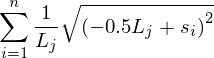

In [30]:
sym.Sum((sym.sqrt(((s_i - (1/2)*L_j)**2))/L_j), (i, 1, n))

In [42]:
more_accurate_mavs = f2.dvars().mavs.ix[:,'smean_ge':]

In [43]:
more_accurate_mavs.to_csv('example-means-and-variances.csv')

In [34]:
f2.dvars().minorAlleleMatrix.to_csv('example-MAF.csv')

In [32]:
def Gcalc(pop, *args, **kwargs):
    '''Function form of the genotypic effect calculator.
    Useful to be able to calculate 'ge' outside of an evolutionary process
    for development purposes.'''
    operators.GenotypicEffectCalculator(g_effect_field='ge').apply(pop)
def Pcalc(pop, *args, **kwargs):
        '''Function form of the truncation selection operator.
    Useful to be able to calculate 'pe' outside of an evolutionary process
    for development purposes.'''
    operators.TruncationSelection(0.7,-101, 
                                  infoFields=['ge','pe']).apply(pop)

In [28]:
Gcalc(f2)

In [33]:
Pcalc(f2)

In [50]:
def peToStdNorm(pop, pe):
    '''Convienience function which converts infoField='pe' of pop
    to a standard normal distribution by subtracting by the mean
    and dividing by the std. deviation.'''
    pop.sortIndividuals('pe', reverse=True)
    pre_normed_phenotypes = np.array(pop.indInfo(pe))
    sim.stat(pop, meanOfInfo='pe', varOfInfo='pe')
    normalized_phenotypes = np.divide(pre_normed_phenotypes-pop.dvars().meanOfInfo['pe'],
                                      math.sqrt(pop.dvars().varOfInfo['pe']))
    return normalized_phenotypes

In [56]:
import math

In [57]:
normalizedPhenotypes = peToStdNorm(f2, 'pe')

In [1]:
def assessDistributionOfPhenotypes(phenotype_array):
    '''Plotting function to examine the distribution
    of phenotypes.'''
    f, axes= plt.subplots(1,2,figsize=(12,8))
    dist_of_phenotypes = np.array(phenotype_array)
    sns.distplot(dist_of_phenotypes, kde=False, color='b', ax=axes[0])
    sns.distplot(dist_of_phenotypes, color='c', ax=axes[1])
    plt.tight_layout()
    return f

In [62]:
assessDistributionOfPhenotypes(normalizedPhenotypes)

In [ ]:
plt.show()

In [36]:
pre_normed_phenotypes = np.array(f2.indInfo('pe'))

In [37]:
sim.stat(f2, meanOfInfo='pe', varOfInfo='pe')

In [38]:
import math as mth

In [43]:
normalized_phenotypes = np.divide(pre_normed_phenotypes - f2.dvars().meanOfInfo['pe'], 
          mth.sqrt(f2.dvars().varOfInfo['pe']))

In [42]:
f2.addInfoFields('normal_pe')

In [47]:
f2.setIndInfo(list(normalized_phenotypes), 'normal_pe')

In [48]:
f2.indInfo('normal_pe')

(3.70634676214188,
 3.1379383241571555,
 3.1180809912598377,
 2.8443706242299296,
 2.8253036727356076,
 2.619348741048233,
 2.6073292415483,
 2.55858984457516,
 2.52218783879325,
 2.5168717681019865,
 2.4988335379874207,
 2.3868991574697977,
 2.3596980446023306,
 2.283751659857885,
 2.194312827852311,
 2.1503432954232715,
 2.118804709009563,
 2.0976056446756,
 2.092038760576264,
 2.0819706410223886,
 2.0717000793113396,
 2.066459435405922,
 2.06032536665352,
 2.0514333297768577,
 2.044151530690517,
 2.040376500843557,
 2.0363197656970753,
 2.0283803467453465,
 2.0260834241962438,
 2.0112435475146966,
 2.0017421016813404,
 1.9910074844205667,
 1.989006541378142,
 1.9887649667877787,
 1.9676614845476286,
 1.961505182304346,
 1.9410070961013686,
 1.9402409109747278,
 1.9217270891596434,
 1.9201252426558837,
 1.9199971709647095,
 1.9059226883875846,
 1.9035505222369682,
 1.9028165006703597,
 1.900154842642105,
 1.8856150500093203,
 1.8687488757098303,
 1.8617731178507406,
 1.86158941125893

In [15]:
simf2 = sim.Simulator(f2, rep=5, stealPops=False)

In [16]:
# Regular evolution
exec('import pandas as pd', f2.vars(), f2.vars())
exec('import itertools as ite', f2.vars(), f2.vars())
exec('import datetime as dt', f2.vars(), f2.vars())
exec('import matplotlib.pyplot as plt', f2.vars(), f2.vars())
simf2.evolve(
    initOps=[
        InitGenerationToZero(),
        InitializeMultiGenDataMatrix(['wmeanGe','wvarGe','wmeanPe','wvarPe',
                                      'smean_ge','svar_ge','smean_pe','svar_pe',
                                      'umean_ge','uvar_ge','umean_pe','uvar_pe']),
        sim.Stat(popSize=True),
        sim.PyEval(r"'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations\n'", reps=0),
        ],
    preOps=[
        operators.GenotypicEffectCalculator(g_effect_field='ge'),
        operators.TruncationSelection(0.7,-101, infoFields=['ge','pe']),
        sim.Stat(meanOfInfo=['ge','pe'], varOfInfo=['ge','pe']),
        StoreDataFromCurrentGeneration('ge','pe','wmeanGe','wvarGe','wmeanPe','wvarPe'),
        #sim.Stat(alleleFreq=sim.ALL_AVAIL),
        #GenerateLDPlot('sample-All-Chromosome-LD-plot'),
        #sim.Stat(numOfSegSites=sim.ALL_AVAIL),
        #sim.Stat(effectiveSize=sim.ALL_AVAIL),
        #sim.Stat(neutrality=sim.ALL_AVAIL),
        #sim.Stat(structure=sim.ALL_AVAIL),
        #GenerateMinorAlleleList(),
        #MinorAlleleCounter(),
        sim.PyEval(r"'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], varOfInfo['ge'])"),
        sim.PyEval(r"'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo['pe'], subPopSize)"),
        #TestFileWriter(dt.datetime.now(), 'alleleFrequencies'),
        Sorter('pe'),
        sim.SplitSubPops(sizes=[5]*20+[1900], randomize=False),
        CalcSplitMavs('ge','pe','smean_ge','svar_ge','smean_pe','svar_pe',
              'umean_ge','uvar_ge','umean_pe','uvar_pe'),
        ],
    matingScheme=
            sim.HomoMating(
                sim.PyParentsChooser(recursivePairwiseParentChooser),
                sim.OffspringGenerator(ops=[
                    sim.Recombinator(rates=0.01),
                    sim.IdTagger(),
                    sim.PedigreeTagger()],
                    numOffspring=1),
                subPopSize=[150]*20+[0],
                subPops=list_of_applicable_subpops,
                ),
    postOps=[
        sim.MergeSubPops(),
        SelectRandomSeed(1000),
        ],
    #finalOps=PlotMeansAndVariances("sample-Means-and-Variances-Over-Time.jpg"),
    gen=7)

Applied <simuPOP.PyOperator> calling a Python function setGenerationToZero: 0
Applied <simuPOP.PyOperator> calling a Python function createMultiGenDataMatrix: 0
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate population size
</ul>: 0
Applied <simuPOP.PyEval> evalulate expression "'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations... ": 0
Applied <simuPOP.PyOperator> calling a Python function setGenerationToZero: 0
Applied <simuPOP.PyOperator> calling a Python function createMultiGenDataMatrix: 0.001
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate population size
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function setGenerationToZero: 0
Applied <simuPOP.PyOperator> calling a Python function createMultiGenDataMatrix: 0
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate population size
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function setGenerationToZero: 0
Applied <simuPOP.PyOperator> calling a Python function createMult

Gen	MeanGe	VarGe	MeanPe	VarPe	SubPopulations



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.759
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.008
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.002
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 0: 0
Mating finished.: 0.276
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

0	66.039	3.319	66.035	4.922	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.214
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.003
Start mating at generation 0: 0
Mating finished.: 0.291
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

0	66.039	3.319	66.006	4.988	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.012
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 0: 0
Mating finished.: 0.28
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndice

0	66.039	3.319	66.056	4.962	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.918
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 0: 0
Mating finished.: 0.279
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.01

0	66.039	3.319	66.051	4.948	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.961
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.004
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.007
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.003
Start mating at generation 0: 0
Mating finished.: 0.283
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.011
A

0	66.039	3.319	66.058	5.048	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.889
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.006
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.003
Start mating at generation 1: 0
Mating finished.: 0.274
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

1	69.025	2.069	69.021	4.435	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.945
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.007
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.003
Start mating at generation 1: 0
Mating finished.: 0.261
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

1	69.002	2.090	69.062	4.693	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.985
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.008
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 1: 0
Mating finished.: 0.25
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndice

1	69.047	2.161	69.023	4.310	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.811
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.006
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 1: 0
Mating finished.: 0.289
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

1	69.191	2.206	69.173	4.440	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.934
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 1: 0
Mating finished.: 0.273
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

1	69.139	2.026	69.101	4.168	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.744
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 2: 0
Mating finished.: 0.255
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

2	71.043	1.106	71.026	8.527	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.727
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 2: 0
Mating finished.: 0.266
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

2	70.886	1.212	70.830	6.716	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.751
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 2: 0
Mating finished.: 0.264
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

2	70.987	1.196	71.020	6.819	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.688
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.004
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 2: 0
Mating finished.: 0.256
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

2	71.194	1.047	71.258	10.212	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.722
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.008
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.006
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.004
Start mating at generation 2: 0
Mating finished.: 0.246
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

2	70.914	1.169	70.919	7.501	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.729
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.008
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.002
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.007
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 3: 0
Mating finished.: 0.261
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeIndic

3	71.700	0.770	72.121	126.383	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.79
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.008
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 3: 0
Mating finished.: 0.26
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeInd

3	71.752	0.867	71.563	28.332	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.746
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.008
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.001
Start mating at generation 3: 0
Mating finished.: 0.257
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.01

3	71.745	0.811	71.620	57.359	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.198
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.007
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.001
Start mating at generation 3: 0
Mating finished.: 0.301
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

3	71.791	0.656	71.361	222.847	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.985
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 3: 0
Mating finished.: 0.257
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

3	71.822	0.693	74.976	9430.430	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.674
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 4: 0
Mating finished.: 0.317
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

4	71.879	0.573	71.693	21.385	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.766
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 4: 0
Mating finished.: 0.245
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeIndic

4	71.997	0.676	71.958	757.860	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.764
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.003
Start mating at generation 4: 0
Mating finished.: 0.259
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

4	71.941	0.702	78.040	116002.117	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.668
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.004
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 4: 0
Mating finished.: 0.257
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.01

4	71.875	0.649	72.482	161.345	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.876
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.004
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.001
Start mating at generation 4: 0
Mating finished.: 0.256
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeIndic

4	71.812	0.728	71.559	708.143	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.651
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.004
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.001
Start mating at generation 5: 0
Mating finished.: 0.314
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

5	72.038	0.543	72.148	11.958	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.639
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.006
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.003
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 5: 0
Mating finished.: 0.26
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndice

5	72.004	0.707	76.260	10579.416	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.763
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.004
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.004
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.001
Start mating at generation 5: 0
Mating finished.: 0.264
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 

5	72.003	0.649	72.146	161.164	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.651
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0.001
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 5: 0
Mating finished.: 0.247
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

5	71.915	0.612	71.837	48.160	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.819
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 5: 0
Mating finished.: 0.307
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeI

5	71.843	0.668	71.330	408.055	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.39
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.007
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 6: 0
Mating finished.: 0.299
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0

6	72.378	0.436	72.307	3.126	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.082
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.008
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.002
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.004
Start mating at generation 6: 0
Mating finished.: 0.307
Applied <simuPOP.merge subpopulations>: 0.001
Applied <simuPOP.PyOperator> calling a Python function removeI

6	71.982	0.751	72.143	204.575	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.032
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.006
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0.001
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 6: 0
Mating finished.: 0.265
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

6	72.058	0.639	72.422	110.410	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.969
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.005
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.002
Start mating at generation 6: 0
Mating finished.: 0.265
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndic

6	72.001	0.552	72.122	14.586	[2000]



pplied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.943
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.005
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.001
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.007
Applied <simuPOP.split subpopulation>: 0
Applied <simuPOP.PyOperator> calling a Python function splitAndCombineCalculator: 0.003
Start mating at generation 6: 0
M

6	71.870	0.676	71.762	797.864	[2000]


ating finished.: 0.298
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.013


(7, 7, 7, 7, 7)

In [23]:
simf2.dvars(4).mavs

,wmeanGe,wvarGe,wmeanPe,wvarPe,smean_ge,svar_ge,smean_pe,svar_pe,umean_ge,uvar_ge,umean_pe,uvar_pe
0,66.038636,3.318662,66.058046,5.048220,70.291715,1.772450,72.812698,0.319762,69.668673,1.712806,72.022656,0.026131
1,69.139347,2.026423,69.101063,4.167597,71.543995,0.584141,74.898232,0.071913,71.137244,0.835477,74.495944,0.011756
2,70.913748,1.169154,70.919318,7.501037,72.039026,0.193982,79.311372,0.526537,72.306128,0.414806,78.059336,0.130980
3,71.821873,0.693018,74.976314,9430.429905,71.751405,0.872857,396.455224,130.464536,71.810487,0.831187,331.844479,39.722996
4,71.812022,0.727596,71.559251,708.143124,71.696922,0.640835,148.113040,8.118102,71.696903,1.090232,141.621399,2.933786
5,71.843424,0.667590,71.329967,408.055135,72.546355,0.137207,130.243497,7.269252,71.835812,0.819888,125.850984,0.450363
6,71.870203,0.676201,71.761642,797.863661,71.938933,1.144175,152.526651,13.601673,71.291713,4.212925,141.652007,2.128761


In [106]:
def createMavsPlot(self,pop):
    mavs = pop.dvars().mavs
    num_of_gens = pop.dvars().gen
    f, axarr = plt.subplots(figsize=(24,12),nrows=2, ncols=1)
    ax_mean = axarr[0]
    ax_var = axarr[1]
    x = np.array(list(mavs.index))
    f.suptitle("Means and Variances Over Time", fontsize=20, fontweight="bold")
    
    y_mean_ge = np.array(mavs.meanGe); y_mean_pe = np.array(mavs.meanPe)
    ax_mean.set_title("Means of Ge and Pe", fontsize=16)
    ax_mean.set_xlim(-0.5, num_of_gens - 0.5)
    ax_mean.set_ylim(-0.5, max(mavs.max())+2.5)
    ax_mean.grid(True)
    ax_mean.set_yticks(np.arange(0,max(mavs.max())+2.5),2)
    ax_mean.plot(x, y_mean_ge, "g*-", label="Mean Ge", ms=8, alpha=0.5)
    ax_mean.plot(x, y_mean_pe, "ro--", label="Mean Pe", ms=8, alpha=0.5)
    mean_legend_handles, mean_legend_labels = ax_mean.get_legend_handles_labels()
    ax_mean.legend(mean_legend_handles, mean_legend_labels, loc='lower right')
    
    y_var_ge = np.array(mavs.varGe); y_var_pe = np.array(mavs.varPe)
    ax_var.set_title("Variances of Ge and Pe", fontsize=16)
    ax_var.set_xlim(-0.5, num_of_gens - 0.5)
    ax_var.set_ylim(-0.5, max(mavs.max())+2.5)
    ax_var.grid(True)
    ax_var.set_xlabel("Generations", fontsize=12)
    ax_var.plot(x, y_var_ge, "gd-", label="Variance Ge", ms=8, alpha=0.5)
    ax_var.plot(x, y_var_pe, "r^--", label="Variance Pe", ms=8, alpha=0.5)
    var_legend_handles, var_legend_labels = ax_var.get_legend_handles_labels()
    ax_var.legend(var_legend_handles, var_legend_labels)    
    plt.savefig(self.output_filename,dpi=300)    

In [58]:
def LDHeatMapAllChromosomes(pop):
    sns.set(context="paper",style='ticks', palette='Set2')
    ldframe = pd.DataFrame(pop.dvars().R2)
    f, ax = plt.subplots(figsize=(24,12))
    f.suptitle("All Chromosomes", fontsize=20, fontweight='bold')
    sns.heatmap(ldframe, vmax=1.0, xticklabels=50,
    yticklabels=50,square=True)
    ax.set_title("Generation: %d, Number Of QTL: %d, Population Size: %d, Selection Intensity: %.2f"\
                 % (pop.dvars().gen, len(pop.dvars().properQTL), pop.popSize(), pop.dvars().selectionIntensity),
                fontsize=16)
    f.axes[1].set_title(r'$R^2$', fontsize=18)
    ax.set_xlabel("cM", fontsize=16)
    ax.set_ylabel("cM", fontsize=16)
    plt.savefig('sb-ld-heatmap.jpg',dpi=300)
    return f

In [66]:
f2.dvars().lociPairs = lpairs

In [61]:
import seaborn as sns
sns.set(context='paper', style='dark', palette='Set2', font='serif')

In [63]:
f2.dvars().selectionIntensity = 0.05

In [64]:
LDHeatMapAllChromosomes(f2)

In [14]:
# Regular evolution
simmedf2.evolve(
    initOps=[
        InitGenerationToZero(),
        InitializeMultiGenDataMatrix(['meanGe','varGe','meanPe','varPe']),
        sim.Stat(popSize=True),
        sim.PyEval(r"'Gen\tRep\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations\n'", reps=0),
        ],
    preOps=[
        operators.GenotypicEffectCalculator(g_effect_field='ge'),
        operators.TruncationSelection(0.7,-201, infoFields=['ge','pe']),
        #sim.Stat(popSize=True),
        sim.Stat(meanOfInfo=['ge','pe'], varOfInfo=['ge','pe']),
        sim.Stat(alleleFreq=sim.ALL_AVAIL),
        sim.Stat(LD=loci_pairs, vars=['R2'])
        #sim.Stat(numOfSegSites=sim.ALL_AVAIL),
        #sim.Stat(effectiveSize=sim.ALL_AVAIL),
        #sim.Stat(neutrality=sim.ALL_AVAIL),
        #sim.Stat(structure=sim.ALL_AVAIL),
        #AllPairwiseLDCalculator()
        #GenerateMinorAlleleList(),
        #MinorAlleleCounter(),
        #sim.Dumper(loci=[0,1,2], structure=False, max=210),
        sim.PyEval(r"'\n%d\t%d\t%.3f\t%.3f\t' % (gen, rep, meanOfInfo['ge'], varOfInfo['ge'])"),
        sim.PyEval(r"'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo['pe'], subPopSize)"),
        StoreDataFromCurrentGeneration('ge','pe','meanGe','varGe','meanPe','varPe'),
        #TestFileWriter(dt.datetime.now(), 'alleleFrequencies'),
        Sorter('pe'),
        sim.SplitSubPops(sizes=[5]*40+[int(remainder)], randomize=False),
        ],
    matingScheme=
            sim.HomoMating(
                sim.PyParentsChooser(recursivePairwiseParentChooser),
                sim.OffspringGenerator(ops=[
                    sim.Recombinator(rates=0.01),
                    sim.IdTagger(),
                    sim.PedigreeTagger()],
                    numOffspring=1),
                subPopSize=[75]*40+[0],
                subPops=list_of_applicable_subpops,
                ),
    postOps=[
        sim.MergeSubPops(),
        SelectRandomSeed(1000),
        ],
    gen=2)

Gen	Rep	MeanGe	VarGe	MeanPe	VarPe	SubPopulations

0	0	14.588	0.143	14.592	0.212	[2000]

0	1	14.588	0.143	14.592	0.211	[2000]

0	2	14.588	0.143	14.584	0.208	[2000]

0	3	14.588	0.143	14.580	0.211	[2000]

0	4	14.588	0.143	14.591	0.207	[2000]

0	5	14.588	0.143	14.595	0.205	[2000]

0	6	14.588	0.143	14.584	0.221	[2000]

0	7	14.588	0.143	14.578	0.214	[2000]

0	8	14.588	0.143	14.586	0.208	[2000]

0	9	14.588	0.143	14.588	0.195	[2000]

1	0	15.154	0.016	15.154	0.017	[2000]

1	1	15.132	0.029	15.132	0.031	[2000]

1	2	15.104	0.035	15.103	0.038	[2000]

1	3	15.115	0.032	15.116	0.035	[2000]

1	4	15.133	0.028	15.131	0.030	[2000]

1	5	15.134	0.025	15.133	0.026	[2000]

1	6	15.144	0.020	15.146	0.021	[2000]

1	7	15.154	0.020	15.154	0.020	[2000]

1	8	15.139	0.027	15.139	0.029	[2000]

1	9	15.134	0.029	15.134	0.031	[2000]


(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [22]:
simmedf2.dvars(9).meanOfInfo['pe'] == simmedf2.dvars(8).meanOfInfo['pe']

False

In [16]:
#Large Scale Simulation

In [16]:
header, mapdata, mapsubset=parse.mapParser('hapmap3.txt')
ends, chromdistances = parse.endPtFinder(mapsubset)
founderPopulation=sim.Population(N, loci=chromdistances, 
                                 alleleNames=nucleotides, 
                                 infoFields=['ind_id',
                                            'father_id','mother_id',
                                            'ge','pe','fitness'])
param.genotypeSetter(founderPopulation,'neat.txt')
f1 = f1Crosses.fOneCross(founderPopulation, size=1, female_idx=17, male_idx=6)
# F2 population size
M = 10000
f2 = f2Crosses.fTwoCross(f1, M)
# absoluteQTL use absolute indices of qtl so there are 2x items in absoluteQTL than QTL 
absoluteQTL, properQTL = qtlChooser(f2, 5)
f2.dvars().qtl = absoluteQTL
f2.dvars().properQTL = properQTL
alleleEffects, plottingAlleleEffects = expAlleleEffectsMap(f2,2)
f2.dvars().alleleEffects = alleleEffects; f2.dvars().plottingAlleleEffects = plottingAlleleEffects
f2.dvars().minorAlleleMatrix = pd.DataFrame(np.zeros((M, f2.totNumLoci())))
numberOfGenerations = 10
sim.tagID(f2, reset=True)
selection_intensity = .05
f2.dvars().selectionIntensity = selection_intensity
number_of_selected = f2.popSize() * selection_intensity
remainder = f2.popSize() - number_of_selected
number_of_breeding_subpops = int(number_of_selected / 5)
list_of_applicable_subpops = list(range(1,number_of_breeding_subpops))
f2.dvars().lociPairs = createLociPairsForLDCalc(f2)

Start evolution.: 0
Start mating at generation 0: 0
Mating finished.: 0.011
Start evolution.: 0
Start mating at generation 1: 0
Mating finished.: 0.912


In [17]:
sim.turnOnDebug('DBG_PROFILE')

In [17]:
exec('import pandas as pd', f2.vars(), f2.vars())
exec('import itertools as ite', f2.vars(), f2.vars())
exec('import datetime as dt', f2.vars(), f2.vars())
exec('import matplotlib.pyplot as plt', f2.vars(), f2.vars())
f2.evolve(
    initOps=[
        InitGenerationToZero(),
        InitializeMultiGenDataMatrix(['meanGe','varGe','meanPe','varPe']),
        sim.Stat(popSize=True),
        sim.PyEval(r"'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations\n'"),
        ],
    preOps=[
        operators.GenotypicEffectCalculator(g_effect_field='ge'),
        operators.TruncationSelection(0.7,-501, infoFields=['ge','pe']),
        sim.Stat(meanOfInfo=['ge','pe'], varOfInfo=['ge','pe']),
        sim.Stat(alleleFreq=sim.ALL_AVAIL),
        #GenerateLDPlot('sample-All-Chromosome-LD-plot'),
        #sim.Stat(numOfSegSites=sim.ALL_AVAIL),
        #sim.Stat(effectiveSize=sim.ALL_AVAIL),
        #sim.Stat(neutrality=sim.ALL_AVAIL),
        #sim.Stat(structure=sim.ALL_AVAIL),
        GenerateMinorAlleleList(),
        MinorAlleleCounter(),
        sim.PyEval(r"'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], varOfInfo['ge'])"),
        sim.PyEval(r"'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo['pe'], subPopSize)"),
        StoreDataFromCurrentGeneration('ge','pe','meanGe','varGe','meanPe','varPe'),
        #TestFileWriter(dt.datetime.now(), 'alleleFrequencies'),
        Sorter('pe'),
        sim.SplitSubPops(sizes=[5]*100+[9500], randomize=False),
        ],
    matingScheme=
            sim.HomoMating(
                sim.PyParentsChooser(recursivePairwiseParentChooser),
                sim.OffspringGenerator(ops=[
                    sim.Recombinator(rates=0.01),
                    sim.IdTagger(),
                    sim.PedigreeTagger()],
                    numOffspring=1),
                subPopSize=[150]*100+[0],
                subPops=list_of_applicable_subpops,
                ),
    postOps=[
        sim.MergeSubPops(),
        SelectRandomSeed(5000),
        ],
    #finalOps=PlotMeansAndVariances("sample-Means-and-Variances-Over-Time.jpg"),
    gen=5)

Applied <simuPOP.PyOperator> calling a Python function setGenerationToZero: 0
Applied <simuPOP.PyOperator> calling a Python function createMultiGenDataMatrix: 0.001
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate population size
</ul>: 0
Applied <simuPOP.PyEval> evalulate expression "'Gen\tMeanGe\tVarGe\tMeanPe\tVarPe\tSubPopulations... ": 0
Start evolution.: 0
Applied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.118
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.029
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.002
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate allele frequency at all loci
</ul>: 1.324
Applied <simuPOP.PyOperator> calling a Python function minorAlleleListGenerator: 0.005
A

Gen	MeanGe	VarGe	MeanPe	VarPe	SubPopulations



pplied <simuPOP.PyOperator> calling a Python function minorAlleleCounter: 8.472
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.041
Applied <simuPOP.split subpopulation>: 0
Start mating at generation 0: 0
Mating finished.: 1.429
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.069
Applied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.109
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.025
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.0

0	12.615	3.563	12.618	5.108	[10000]



pplied <simuPOP.PyOperator> calling a Python function minorAlleleCounter: 8.466
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.036
Applied <simuPOP.split subpopulation>: 0
Start mating at generation 1: 0
Mating finished.: 1.574
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.066
Applied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.981
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.027
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.004
A

1	15.474	0.625	15.466	70.363	[10000]



pplied <simuPOP.PyOperator> calling a Python function minorAlleleCounter: 8.595
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.039
Applied <simuPOP.split subpopulation>: 0
Start mating at generation 2: 0
Mating finished.: 1.578
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.06
Applied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 3.404
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.023
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.00

2	15.623	0.470	15.667	4.699	[10000]



pplied <simuPOP.PyOperator> calling a Python function minorAlleleCounter: 8.093
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.002
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.032
Applied <simuPOP.split subpopulation>: 0
Start mating at generation 3: 0
Mating finished.: 1.293
Applied <simuPOP.merge subpopulations>: 0
Applied <simuPOP.PyOperator> calling a Python function removeIndices: 0.063
Applied <simuPOP.PyOperator> calling a Python function populationInformationPasser: 2.901
Applied <simuPOP.PyOperator> calling a Python function assignFitness: 0.023
Applied <simuPOP.Stat> Calculate statistics
<ul>
<li>calculate
<ul>/n<li>Mean of information fields ge, pe
<li>Variance of information fields ge, pe
</ul>
</ul>: 0.002
A

3	16.012	0.204	16.013	0.369	[10000]



pplied <simuPOP.PyOperator> calling a Python function minorAlleleCounter: 8.14
Applied <simuPOP.PyEval> evalulate expression "'\n%d\t%.3f\t%.3f\t' % (gen, meanOfInfo['ge'], var... ": 0.001
Applied <simuPOP.PyEval> evalulate expression "'%.3f\t%.3f\t%s\n' % (meanOfInfo['pe'], varOfInfo[... ": 0
Applied <simuPOP.PyOperator> calling a Python function inputDataToMatrix: 0.001
Applied <simuPOP.PyOperator> calling a Python function sortOnInfoField: 0.031
Applied <simuPOP.split subpopulation>: 0
Start mating at generation 4: 0.001
Mating finished.: 1.275
Applied <simuPOP.merge subpopulations>: 0
A

4	16.374	0.012	16.374	0.012	[10000]


pplied <simuPOP.PyOperator> calling a Python function removeIndices: 0.059


5

In [ ]:
class DataFileWriter(sim.PyOperator):
    '''Operator to collect the matrix-form statistics of the population
    such as LD(R2) and alleleFreq for all loci. The function fileWriter 
    integrates a timestamp into each filename. A microsecond timestamp as a filename
    guarantees files are 1) ordered and 2) not overwritten.'''
    def __init__(self, timestamp, ld_file_name, allele_frq_file_name, *args, **kwargs):
        self.timestamp = timestamp # timestamp = dt.datetime.now()
        # will be writing these as .csv files, append suffix
        self.ld_file_name = ld_file_name + '.csv'
        self.allele_frq_file_name = allele_frq_file_name + '.csv'
        sim.PyOperator.__init__(self, func=self.fileWriter, *args, **kwargs)
    
    def fileWriter(self, pop):
        # Annoying splitting routine to get timestamp as a string 
        # which can be written as a filename
        split_timestamp = str(self.timestamp).split(':',maxsplit=-1)
        date = split_timestamp[0].split()[0]
        hour = split_timestamp[0].split()[1]
        minute = split_timestamp[1]
        second = split_timestamp[2]
        prefix_timestamp = date+'--'+hour+'_'+minute+'_'+second
        allele_frq_frame = pd.DataFrame(pop.dvars().alleleFreq).T.fillna(0)
        ld_frame = pd.DataFrame(pop.dvars().R2).fillna(0)
        pd.to_csv(prefix_timestamp+self.allele_frq_file_name)
        pd.to_csv(prefix_timestamp+self.ld_file_name)
        return True

# Plotting #

In [38]:
blueLine = mpatches.Patch(color='blue', label='A')
greenLine = mpatches.Patch(color='green', label='C')
redLine = mpatches.Patch(color='red', label='G')
yellowLine = mpatches.Patch(color='yellow', label = 'T')
orangeLine = mpatches.Patch(color='orange', label = 'D')
brownLine = mpatches.Patch(color='brown', label = 'I')
markerSize=6
plottingAlleleEffects['0'].plot(figsize=(10,8), color='blue',linewidth=0, marker='o', mec='blue', markersize=markerSize, label='A')
plottingAlleleEffects['1'].plot(color='green', linewidth=0, marker='o', mec='green', markersize=markerSize, label='C')
plottingAlleleEffects['2'].plot(color='red', linewidth=0, marker='o', mec='red', markersize=markerSize, label='G')
plottingAlleleEffects['3'].plot(color='yellow', linewidth=0, marker='o', mec='yellow', markersize=markerSize, label='T')
plottingAlleleEffects['4'].plot(color='orange', linewidth=0, marker='o',markersize=markerSize, label='D')
plottingAlleleEffects['5'].plot(color='brown', linewidth=0, marker='o', mec='brown', markersize=markerSize, label='I')
plt.title('Allele Effects By Locus')
#plt.xticks(f2.dvars().qtl)
plt.legend(handles=[blueLine,greenLine, redLine, yellowLine, orangeLine, brownLine])

In [39]:
plt.show()

In [41]:
fig.suptitle('Means and Variances of Ge,Pe Over Time', fontsize=16, fontweight='bold')

In [ ]:
fig, ax0 = plt.subplots(nrows=1)
x = np.array(list(pale.index))
y = np.array(list(pale['0']))
ax0.plot(x,y)
ax0.set_title('firstry')
plt.show()

In [24]:
infoLoci = list(range(f2.totNumLoci()))
sim.stat(f2, heteroFreq=infoLoci)
lineotypeFreqs = pd.DataFrame([sb73, sHybrid, sb97]).T
lineotypeFreqs.columns = ['b73', 'hybrid','b97']
tix = []
tickmark=0
for dist in chromdistances:
    tickmark += dist
    tix.append(tickmark)
#cumulative sums of chromosomes lengths
# need labels for plot as well
tix
chromdistances
chromLabels = ['chr1','chr2','chr3','chr4',
               'chr5','chr6','chr7','chr8','chr9','chr10']
import matplotlib.patches as mpatches
blueLine = mpatches.Patch(color='blue',label='b73')
greenLine = mpatches.Patch(color='green',label='hybrid')
redLine = mpatches.Patch(color='red',label='b97')
lineotypeFreqs['b73'].plot(ylim=[0,1.0],figsize=(18,8), color='blue',linewidth=0, marker='o', mec='blue', markersize=2, label='b73')
lineotypeFreqs['hybrid'].plot(color='green',linewidth=0, marker='o', mec='green', markersize=2, label='hybrid')
lineotypeFreqs['b97'].plot(color='red',linewidth=0, marker='o', mec='red', markersize=2, label='b97')
plt.xticks(tix,chromLabels, rotation=45)
plt.xlabel('Locus Index')
plt.ylabel('Frequency')
plt.title('F2 Lineotype Frequencies')
plt.legend(handles=[blueLine, greenLine, redLine])
plt.plot(grid=True)
plt.axhline(y=0.5, xmin=0, xmax=1478, color = 'gray',linewidth=1)
plt.show()

NameError: name 'sb73' is not defined

In [262]:
# Plotting code for the allele frequencies for all loci
blueLine = mpatches.Patch(color='blue', label='A')
greenLine = mpatches.Patch(color='green', label='C')
redLine = mpatches.Patch(color='red', label='G')
yellowLine = mpatches.Patch(color='yellow', label = 'T')
orangeLine = mpatches.Patch(color='orange', label = 'D')
brownLine = mpatches.Patch(color='brown', label = 'I')
markerSize=6
df[0].plot(figsize=(10,8),xlim=[-10.0,1490.0],ylim=[-0.1,1.2], color='blue',linewidth=0, marker='o', mec='blue', markersize=markerSize, label='A')
df[1].plot(color='green', linewidth=0, marker='o', mec='green', markersize=markerSize, label='C')
df[2].plot(color='red', linewidth=0, marker='o', mec='red', markersize=markerSize, label='G')
df[3].plot(color='yellow', linewidth=0, marker='o', mec='yellow', markersize=markerSize, label='T')
df[4].plot(color='orange', linewidth=0, marker='o', mec='orange', markersize=markerSize, label='D')
df[5].plot(color='brown', linewidth=0, marker='o', mec='brown', markersize=markerSize, label='I')
plt.title('Allele Effects By Locus')
plt.legend(handles=[blueLine,greenLine, redLine, yellowLine, orangeLine, brownLine])

In [30]:
def testPlotMeansTogether():
    fig = plt.figure(figsize=(18,10))
    ax_mean = fig.add_subplot(1,1,1)
    x = np.array(list(mavs.index))
    y_ge = np.array(mavs.meanGe)
    y_pe = np.array(mavs.meanPe)
    ax_mean.set_title("Change of MeanGe and MeanPe Over Time")
    ax_mean.set_xlim(-0.5, 4.5)
    ax_mean.plot(x, y_ge, "g*", label='meanGe', linewidth=0.0, ms=8)
    ax_mean.plot(x, y_pe, "ro", label='meanPe', linewidth=0.0, ms=8)
    plt.show()

In [31]:
testPlotMeansTogether()

In [32]:
def testPlotVariancesTogether():
    fig = plt.figure(figsize=(18,10))
    ax_var = fig.add_subplot(1,1,1)
    x = np.array(list(mavs.index))
    y_ge = np.array(mavs.varGe)
    y_pe = np.array(mavs.varPe)
    ax_var.set_title("Variance of Ge and Pe Over Time")
    ax_var.set_xlim(-0.5, 4.5)
    ax_var.plot(x, y_ge, "gd", label="varGe", linewidth=0.0, ms=8)
    ax_var.plot(x, y_pe, "r^", label="varPe", linewidth=0.0, ms=8)
    plt.show()

In [33]:
testPlotVariancesTogether()

In [44]:
"""Examples illustrating the use of plt.subplots().

This function creates a figure and a grid of subplots with a single call, while
providing reasonable control over how the individual plots are created.  For
very refined tuning of subplot creation, you can still use add_subplot()
directly on a new figure.
"""

import matplotlib.pyplot as plt
import numpy as np

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plt.show()

In [101]:
plottingAlleleEffects

,0,1,2,3,4,5
102,0.269818,0.246788,1.084127,0.345775,0.161507,0.497875
103,0.024009,0.852726,0.001371,1.327541,0.171131,0.006963
104,0.024009,0.852726,0.001371,1.327541,0.171131,0.006963
379,0.108633,0.451366,1.499156,0.406907,1.012487,0.469268
380,0.370689,0.232062,0.335608,0.220176,0.276755,0.308882
381,0.370689,0.232062,0.335608,0.220176,0.276755,0.308882
396,0.852668,0.197082,0.853683,0.106318,0.337613,0.108234
397,0.382308,0.667066,0.163594,0.314281,0.237867,0.939661
398,0.382308,0.667066,0.163594,0.314281,0.237867,0.939661
1122,0.224510,0.055353,0.455021,0.150401,0.152998,0.137616


In [51]:
def testPlotMaVsTogether():
    f, axarr = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
    ax_mean = axarr[0]
    ax_var = axarr[1]
    x = np.array(list(mavs.index))
    ax_mean.set_title("Means of Ge and Pe Over Time"); ax_var.set_title("Variances of Ge and Pe Over Time")
    ax_mean.set_xlim(-0.5, 4.5); ax_var.set_xlim(-0.5, 4.5)
    
    y_mean_ge = np.array(mavs.meanGe); y_mean_pe = np.array(mavs.meanPe)
    ax_mean.plot(x, y_mean_ge, "g*", label="meanGe", linewidth=0.0, ms=8)
    ax_mean.plot(x, y_mean_pe, "ro", label="meanPe", linewidth=0.0, ms=8)
    
    y_var_ge = np.array(mavs.varGe); y_var_pe = np.array(mavs.varPe)
    ax_var.plot(x, y_var_ge, "gd", label="varGe", linewidth=0.0, ms=8)
    ax_var.plot(x, y_var_pe, "r^", label="varPe", linewidth=0.0, ms=8)
    
    plt.show()
    

In [52]:
testPlotMaVsTogether()

In [107]:
f2.dvars().properQTL

[67, 367, 436, 957, 1349]

In [108]:
sub_ae_matrix = pd.DataFrame([f2.dvars().plottingAlleleEffects.ix['66',:], 
         f2.dvars().plottingAlleleEffects.ix['67',:],
         f2.dvars().plottingAlleleEffects.ix['68',:]])

In [109]:
subae

,0,1,2,3,4,5
66,0.199742,0.185310,0.052617,0.514806,0.002098,0.028046
67,1.275904,0.543612,0.302884,0.284639,0.145510,0.473843
68,0.082538,2.938334,0.078113,0.180790,1.499378,0.110329


In [69]:
np.array(list(subae.index))

array(['102', '103', '103'], 
      dtype='<U3')

In [124]:
f2.dvars().plottingAlleleEffects

,0,1,2,3,4,5
66,0.199742,0.185310,0.052617,0.514806,0.002098,0.028046
67,1.275904,0.543612,0.302884,0.284639,0.145510,0.473843
68,0.082538,2.938334,0.078113,0.180790,1.499378,0.110329
366,0.066150,0.202834,0.004399,0.177892,0.214152,0.007303
367,0.308959,0.253841,0.064502,0.494971,0.693748,0.038264
368,0.081957,0.390307,0.000047,0.941009,0.205587,0.320603
435,0.634013,0.326882,0.898351,0.034751,0.246533,0.065299
436,0.504030,0.028640,0.190321,0.989037,0.224150,0.645941
437,0.239488,0.237018,0.956547,1.666265,0.369828,0.005949
956,0.315905,0.172129,0.346653,0.118284,0.981513,0.495045


In [18]:
def testPlotSingleAETriplet():
    number_qtl = 5
    qtl_list = f2.dvars().properQTL
    ae_matrix = plottingAlleleEffects
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Allele Effects of Single Triplet")
    ax.set_xlim(65.9, 68.1)
    ax.set_ylim(-0.1, 1.6)
    ax.grid(True)
    
    sub_ae_matrix = pd.DataFrame([f2.dvars().plottingAlleleEffects.ix['66',:], 
         f2.dvars().plottingAlleleEffects.ix['67',:],
         f2.dvars().plottingAlleleEffects.ix['68',:]])
    
    x = np.array(list(sub_ae_matrix.index))
    y0 = np.array(sub_ae_matrix['0'])
    y1 = np.array(sub_ae_matrix['1'])
    y2 = np.array(sub_ae_matrix['2'])
    y3 = np.array(sub_ae_matrix['3'])
    y4 = np.array(sub_ae_matrix['4'])
    y5 = np.array(sub_ae_matrix['5'])
    
    ax.plot(x, y0, "rs", label="A", linewidth=0.0, ms=8, alpha=0.8)
    ax.plot(x, y1, "bp", label="A", linewidth=0.0, ms=8, alpha=0.8)
    ax.plot(x, y2, "gh", label="A", linewidth=0.0, ms=8, alpha=0.8)
    ax.plot(x, y3, "c8", label="A", linewidth=0.0, ms=8, alpha=0.8)
    ax.plot(x, y4, "m+", label="A", linewidth=0.0, ms=8, alpha=0.8)
    ax.plot(x, y5, "k-", label="A", linewidth=0.0, ms=8, alpha=0.8)
    plt.show()

In [123]:
testPlotSingleAETriplet()

In [22]:
def generateSubAEMatrix(central_locus):
    left_index = str(central_locus-1)
    central_index = str(central_locus)
    right_index = str(central_locus+1)
    plot_ae_matrix = f2.dvars().plottingAlleleEffects
    sub_ae_matrix = pd.DataFrame([plot_ae_matrix.ix[left_index, :],
                                  plot_ae_matrix.ix[central_index, :],
                                  plot_ae_matrix.ix[right_index,:]])
    return sub_ae_matrix
def AESubplotter(sub_ae_matrix, axis_from_axes_array):
    pre_lims = list(sub_ae_matrix.index)
    lims = [int(pre_lims[0]), int(pre_lims[1]), int(pre_lims[2])]
    x = np.array(list(sub_ae_matrix.index), dtype=int)
    y0 = np.array(sub_ae_matrix['0'])
    y1 = np.array(sub_ae_matrix['1'])
    y2 = np.array(sub_ae_matrix['2'])
    y3 = np.array(sub_ae_matrix['3'])
    y4 = np.array(sub_ae_matrix['4'])
    y5 = np.array(sub_ae_matrix['5'])
    
    axis_from_axes_array.set_xlim(lims[0] - 0.1, lims[2] + 0.1)
    axis_from_axes_array.set_ylim(-0.1, max(sub_ae_matrix.max()) + 0.1)
    axis_from_axes_array.grid(True)
    for label in axis_from_axes_array.get_xticklabels():
        label.set_fontsize(6)
    
    axis_from_axes_array.plot(x, y0, "rs", label="A", linewidth=0, ms=8, alpha=0.9)
    axis_from_axes_array.plot(x, y1, "bp", label="C", linewidth=0, ms=8, alpha=0.9)
    axis_from_axes_array.plot(x, y2, "gh", label="G", linewidth=0, ms=8, alpha=0.9)
    axis_from_axes_array.plot(x, y3, "c8", label="T", linewidth=0, ms=8, alpha=0.9)
    axis_from_axes_array.plot(x, y4, "m+", label="I", linewidth=0, ms=8, alpha=0.9)
    axis_from_axes_array.plot(x, y5, "k-", label="D", linewidth=0, ms=8, alpha=0.9)
def AEPlotControlFunction(population):
    proper_qtl = population.dvars().properQTL
    num_of_subplots = len(proper_qtl)
    f, axes_array = plt.subplots(figsize=(10,8), nrows=1, ncols=num_of_subplots)
    #f.set_suptitle("Plot of Triplet Allele Effects")
    
    for cqi, ax in zip(proper_qtl, axes_array):
        sub_ae_matrix = generateSubAEMatrix(cqi)
        AESubplotter(sub_ae_matrix, ax)
    
    plt.show()

In [35]:
AEPlotControlFunction(f2)

NameError: name 'fig' is not defined

In [16]:
subae

,0,1,2,3,4,5
17,0.054218,0.252958,0.010968,0.086331,0.738032,0.303340
18,0.019081,0.252694,0.142012,0.666201,0.762784,1.973906
19,0.741235,0.639543,0.084423,0.728393,1.107859,0.608349


In [ ]:
def testPlotAllAlleleEffects():
    